In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install wandb


In [3]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import wandb

In [54]:
dataset_path = "/content/drive/MyDrive/5Animals"


In [55]:
width = height = 299
img_data_generator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255 ,
    validation_split=0.1,
)
train_data= img_data_generator.flow_from_directory(
    dataset_path ,
    shuffle=True,
    subset="training",
    target_size=(width,height),
    batch_size=32
)

validation_data = img_data_generator.flow_from_directory(
    dataset_path,
    shuffle=True,
    subset="validation",
    target_size=(width,height),
    batch_size=32
)

Found 1171 images belonging to 5 classes.
Found 128 images belonging to 5 classes.


## train_data is an iterator , so :

In [56]:
next(train_data)[0].shape

(32, 299, 299, 3)

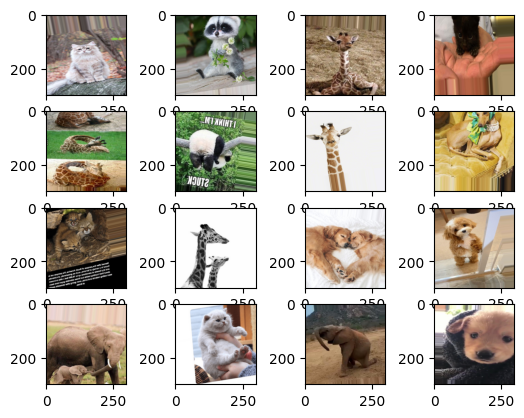

In [57]:
train_images = next(train_data)[0]
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(train_images[i])

## TransferLearning : weights="imagenet"

In [58]:
initial_model = tf.keras.applications.InceptionResNetV2(weights="imagenet" , input_shape=(width,height,3))
initial_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_1218 (Conv2D)        (None, 149, 149, 32)         864       ['input_7[0][0]']             
                                                                                                  
 batch_normalization_1218 (  (None, 149, 149, 32)         96        ['conv2d_1218[0][0]']         
 BatchNormalization)                                                                              
                                                                                                  
 activation_1218 (Activatio  (None, 149, 149, 32)         0         ['batch_norm

## include_top = False :

 ## these 2 layers have been deleted :
 ### because of include_top=False
 avg_pool (GlobalAveragePoo(None,1536))                                                           
 predictions (Dense)(None, 1000)

In [59]:
initial_model = tf.keras.applications.InceptionResNetV2(weights="imagenet" , include_top=False , input_shape=(width,height,3))
initial_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_1421 (Conv2D)        (None, 149, 149, 32)         864       ['input_8[0][0]']             
                                                                                                  
 batch_normalization_1421 (  (None, 149, 149, 32)         96        ['conv2d_1421[0][0]']         
 BatchNormalization)                                                                              
                                                                                                  
 activation_1421 (Activatio  (None, 149, 149, 32)         0         ['batch_norm

## حالا خودمون باید اون دوتا لایه رو بسازیم ::
اما لایه پولینگ رو میتونیم اینجوری بسازیم ::
اینجوری فقط لایه دنس را حذف کردیم

In [60]:
initial_model = tf.keras.applications.InceptionResNetV2(weights="imagenet",
                                                        include_top=False,
                                                        pooling="avg",
                                                        input_shape=(width,height,3))
initial_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_1624 (Conv2D)        (None, 149, 149, 32)         864       ['input_9[0][0]']             
                                                                                                  
 batch_normalization_1624 (  (None, 149, 149, 32)         96        ['conv2d_1624[0][0]']         
 BatchNormalization)                                                                              
                                                                                                  
 activation_1624 (Activatio  (None, 149, 149, 32)         0         ['batch_norm

# FREEZING SOME LAYERS :

نمیخوایم همه ی لایه ها ترین بشن

## اگر بخوایم چهار لایه آخر شبکه فریز نشوند  :
چهارتای آخر را درنظر نمیگیریم
یعنی میخوایم ۴ لایه آخر شبکه ترین بشوند ولی بقیه نه  

In [61]:
for layer in initial_model.layers[:-4]:
 layer.trainable=False

#initial_model.summary()

In [62]:
model = tf.keras.models.Sequential([
    initial_model,
    tf.keras.layers.Dropout(0.2), # 0.2 is probability that a neuron will be inactive and 80% active
    tf.keras.layers.Dense(5 , activation="softmax")
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 1536)              54336736  
 ional)                                                          
                                                                 
 dropout_2 (Dropout)         (None, 1536)              0         
                                                                 
 dense_2 (Dense)             (None, 5)                 7685      
                                                                 
Total params: 54344421 (207.31 MB)
Trainable params: 3204101 (12.22 MB)
Non-trainable params: 51140320 (195.08 MB)
_________________________________________________________________


In [63]:
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001) ,
              loss=tf.keras.losses.categorical_crossentropy ,
              metrics=["accuracy"] )

In [64]:
run = wandb.init(project="5-animals")

batch/accuracy,▁▆▇▇████████████████████████████████████
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▆▇▇██████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▁▁▁▁▁▁
epoch/val_accuracy,▁▇███▇████
epoch/val_loss,█▁▁▁▁▁▁▁▁▁
batch/accuracy,0.99912


In [65]:
from wandb.sdk.wandb_run import wandb_metric
config = wandb.config
from wandb.keras import (
   WandbMetricsLogger,
   WandbModelCheckpoint,
)

wandb_callbacks = [
   WandbMetricsLogger(log_freq=5),
   WandbModelCheckpoint("models"),
]

In [66]:
history = model.fit(train_data , validation_data=validation_data , epochs=10 , callbacks=wandb_callbacks)


Epoch 1/10
37/37 [==============================] - ETA: 0s - loss: 0.1331 - accuracy: 0.9547

wandb: Adding directory to artifact (./models)... Done. 1.2s


37/37 [==============================] - 133s 3s/step - loss: 0.1331 - accuracy: 0.9547 - val_loss: 0.0456 - val_accuracy: 0.9844
Epoch 2/10
37/37 [==============================] - ETA: 0s - loss: 0.0428 - accuracy: 0.9838

wandb: Adding directory to artifact (./models)... Done. 1.2s


37/37 [==============================] - 125s 3s/step - loss: 0.0428 - accuracy: 0.9838 - val_loss: 0.0449 - val_accuracy: 0.9766
Epoch 3/10
37/37 [==============================] - ETA: 0s - loss: 0.0312 - accuracy: 0.9915

wandb: Adding directory to artifact (./models)... Done. 2.0s


37/37 [==============================] - 120s 3s/step - loss: 0.0312 - accuracy: 0.9915 - val_loss: 0.0366 - val_accuracy: 0.9844
Epoch 4/10
37/37 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.9966

wandb: Adding directory to artifact (./models)... Done. 2.7s


37/37 [==============================] - 120s 3s/step - loss: 0.0123 - accuracy: 0.9966 - val_loss: 0.0278 - val_accuracy: 0.9844
Epoch 5/10
37/37 [==============================] - ETA: 0s - loss: 0.0158 - accuracy: 0.9966

wandb: Adding directory to artifact (./models)... Done. 1.6s


37/37 [==============================] - 119s 3s/step - loss: 0.0158 - accuracy: 0.9966 - val_loss: 0.0545 - val_accuracy: 0.9688
Epoch 6/10
37/37 [==============================] - ETA: 0s - loss: 0.0127 - accuracy: 0.9974

wandb: Adding directory to artifact (./models)... Done. 1.2s


37/37 [==============================] - 118s 3s/step - loss: 0.0127 - accuracy: 0.9974 - val_loss: 0.0229 - val_accuracy: 0.9922
Epoch 7/10
37/37 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.9966

wandb: Adding directory to artifact (./models)... Done. 1.2s


37/37 [==============================] - 119s 3s/step - loss: 0.0170 - accuracy: 0.9966 - val_loss: 0.0339 - val_accuracy: 0.9844
Epoch 8/10
37/37 [==============================] - ETA: 0s - loss: 0.0091 - accuracy: 0.9983

wandb: Adding directory to artifact (./models)... Done. 1.3s


37/37 [==============================] - 118s 3s/step - loss: 0.0091 - accuracy: 0.9983 - val_loss: 0.0320 - val_accuracy: 0.9766
Epoch 9/10
37/37 [==============================] - ETA: 0s - loss: 0.0125 - accuracy: 0.9974

wandb: Adding directory to artifact (./models)... Done. 1.2s


37/37 [==============================] - 119s 3s/step - loss: 0.0125 - accuracy: 0.9974 - val_loss: 0.0670 - val_accuracy: 0.9609
Epoch 10/10
37/37 [==============================] - ETA: 0s - loss: 0.0066 - accuracy: 0.9991

wandb: Adding directory to artifact (./models)... Done. 7.0s


37/37 [==============================] - 123s 3s/step - loss: 0.0066 - accuracy: 0.9991 - val_loss: 0.0444 - val_accuracy: 0.9688


| Layers Freezed|without Dropout| with Droput = 0.2 |with Droput = 0.5 |
| ------------- | :-------------: | :-------------: |:-------------: |
| validation Accuracy  | 0.9766  | 0.9922  | 0.9766  |


|without Freezing layers|without Dropout| with Droput = 0.2 | with Droput = 0.5 |
| ------------- | :-------------: | :-------------: | :-------------: |
| validation Accuracy  | 1.0000  | 0.9609  | 1.0000  |


In [67]:
#model.save("/content/drive/MyDrive/5animals_weights.keras")

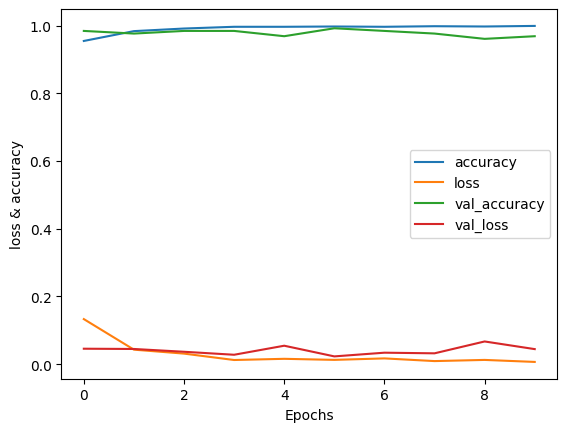

In [68]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["loss"], label='Train')
plt.plot(history.history["val_accuracy"], label='Validation')
plt.plot(history.history["val_loss"])
plt.legend(["accuracy","loss" , "val_accuracy" , "val_loss"])
plt.xlabel("Epochs")
plt.ylabel("loss & accuracy")
plt.show()

In [69]:
#y_pred = model.predict(validation_data)
#y_predlist = np.array(list(y_pred))
#print(y_predlist[5])
#print(np.argmax(y_predlist[5]))
#ypred_list = []
#for i in range(len(y_predlist)):
#  ypred_list.append(np.argmax(y_predlist[i]))

#print(ypred_list)

In [ ]:
images,labels = validation_data[1]
ypred_list = []
for image in images:
    image = np.expand_dims(image, axis=0)
    ypred=model.predict(image)
    ypred_list.append(np.argmax(ypred))
ytrue_list = []
for label in labels:
    ytrue_list.append(np.argmax(label))

In [71]:
np.array(ytrue_list)

array([0, 4, 2, 1, 1, 3, 0, 2, 3, 3, 4, 4, 2, 0, 1, 4, 4, 3, 0, 1, 3, 2,
       0, 4, 0, 1, 4, 0, 4, 0, 4, 1])

In [72]:
np.array(ypred_list)

array([0, 4, 2, 1, 1, 3, 0, 2, 3, 3, 4, 4, 2, 0, 1, 4, 4, 3, 0, 1, 3, 2,
       0, 4, 0, 1, 4, 0, 4, 0, 4, 1])

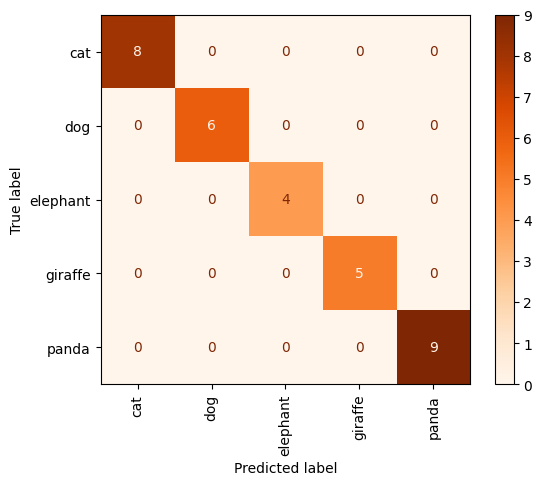

In [73]:
confm = metrics.confusion_matrix(y_true= ytrue_list , y_pred= ypred_list  )
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confm , display_labels=['cat','dog','elephant','giraffe','panda'])
cm_display.plot(cmap=plt.cm.Oranges , xticks_rotation="vertical")
plt.show()

# Inference

In [74]:
#model= tf.keras.models.load_model("/content/drive/MyDrive/5animals_weights.keras")

شبکه همیشه تصاویر را به صورت بچ میخواد از ما . یعنی ورودی شبکه همیشه ۴ بعدی است .
یکی از این ۴ تا بعد بچ سایز است
اما حالا که فقط میخوایم یک تصویر بدیم بازم باید تصویر رو ۴ بعدی بکنیم


1/1 [==============================] - 0s 42ms/step
0
{'cat': 0, 'dog': 1, 'elephant': 2, 'giraffe': 3, 'panda': 4}
predicted label :  cat


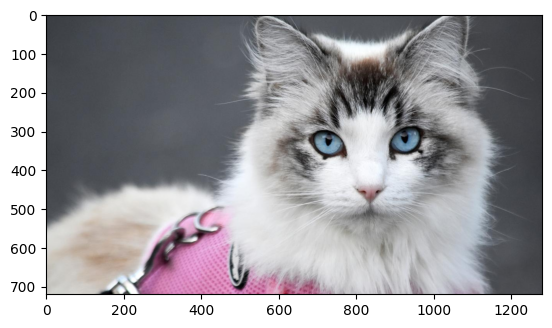

In [75]:
import cv2

new_image = cv2.imread("/content/c3.jpg")
new_image = cv2.cvtColor(new_image , cv2.COLOR_BGR2RGB)
plt.imshow(new_image)
new_image = cv2.resize(new_image , (299,299))
new_image = new_image / 255.0
new_image = np.reshape(new_image, [1, 299, 299, 3]) # new_iamge.reshape(1,299,299,3)

output = model.predict(new_image)

predicted_class = np.argmax(output)
print(predicted_class)
print(train_data.class_indices)
mylist = list(train_data.class_indices)
print("predicted label : " , mylist[np.argmax(output)])

1/1 [==============================] - 0s 43ms/step
1
{'cat': 0, 'dog': 1, 'elephant': 2, 'giraffe': 3, 'panda': 4}
predicted label :  dog


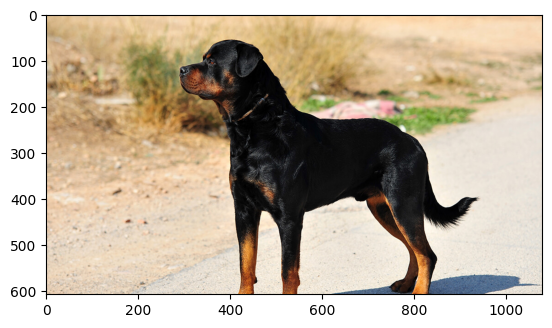

In [76]:
new_image = cv2.imread("/content/dog2.jpg")
new_image = cv2.cvtColor(new_image , cv2.COLOR_BGR2RGB)
plt.imshow(new_image)
new_image = cv2.resize(new_image , (299,299))
new_image = new_image / 255.0
new_image = np.reshape(new_image, [1, 299, 299, 3]) # new_iamge.reshape(1,299,299,3)

output = model.predict(new_image)

predicted_class = np.argmax(output)
print(predicted_class)
print(train_data.class_indices)
mylist = list(train_data.class_indices)
print("predicted label : " , mylist[np.argmax(output)])

1/1 [==============================] - 0s 43ms/step
2
{'cat': 0, 'dog': 1, 'elephant': 2, 'giraffe': 3, 'panda': 4}
predicted label :  elephant


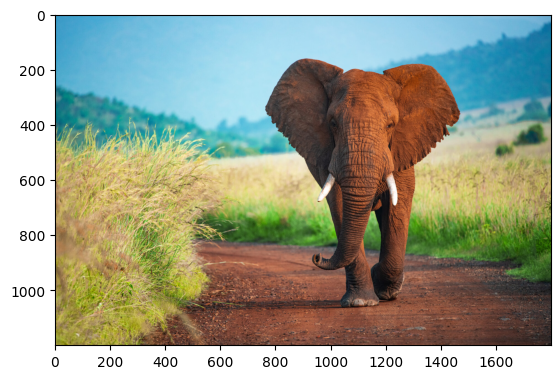

In [77]:
new_image = cv2.imread("/content/ele1.jpg")
new_image = cv2.cvtColor(new_image , cv2.COLOR_BGR2RGB)
plt.imshow(new_image)
new_image = cv2.resize(new_image , (299,299))
new_image = new_image / 255.0
new_image = np.reshape(new_image, [1, 299, 299, 3]) # new_iamge.reshape(1,299,299,3)

output = model.predict(new_image)

predicted_class = np.argmax(output)
print(predicted_class)
print(train_data.class_indices)
mylist = list(train_data.class_indices)
print("predicted label : " , mylist[np.argmax(output)])

1/1 [==============================] - 0s 65ms/step
4
{'cat': 0, 'dog': 1, 'elephant': 2, 'giraffe': 3, 'panda': 4}
predicted label :  panda


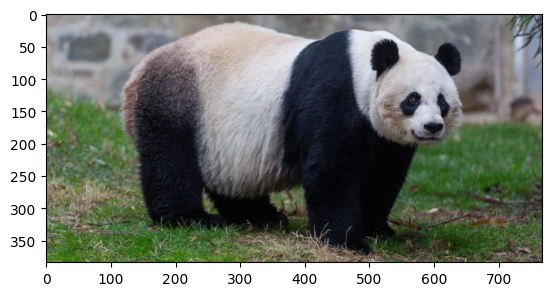

In [78]:
new_image = cv2.imread("/content/pan.jpg")
new_image = cv2.cvtColor(new_image , cv2.COLOR_BGR2RGB)
plt.imshow(new_image)
new_image = cv2.resize(new_image , (299,299))
new_image = new_image / 255.0
new_image = np.reshape(new_image, [1, 299, 299, 3]) # new_iamge.reshape(1,299,299,3)

output = model.predict(new_image)

predicted_class = np.argmax(output)
print(predicted_class)
print(train_data.class_indices)
mylist = list(train_data.class_indices)
print("predicted label : " , mylist[np.argmax(output)])